<a href="https://colab.research.google.com/github/Kecheng-Chen/CS194-26/blob/master/prob3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import packages
from __future__ import print_function, division
import os
import random
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import imgaug.augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import torchvision.models as models
plt.ion()   # interactive mode

In [2]:
import os
import xml.etree.ElementTree as ET 
import numpy as np

In [ ]:
if not os.path.exists('/content/ibug_300W_large_face_landmark_dataset'):
    !wget https://people.eecs.berkeley.edu/~zhecao/ibug_300W_large_face_landmark_dataset.zip
    !unzip 'ibug_300W_large_face_landmark_dataset.zip'    
    !rm -r 'ibug_300W_large_face_landmark_dataset.zip'

In [4]:
tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
root = tree.getroot()
root_dir = 'ibug_300W_large_face_landmark_dataset'

bboxes = [] # face bounding box used to crop the image
landmarks = [] # the facial keypoints/landmarks for the whole training dataset
img_filenames = [] # the image names for the whole dataset

for filename in root[2]:
	img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
	box = filename[0].attrib
	# x, y for the top left corner of the box, w, h for box width and height
	bboxes.append([box['left'], box['top'], box['width'], box['height']]) 

	landmark = []
	for num in range(68):
		x_coordinate = int(filename[0][num].attrib['x'])
		y_coordinate = int(filename[0][num].attrib['y'])
		landmark.append([x_coordinate, y_coordinate])
	landmarks.append(landmark)

landmarks = np.array(landmarks).astype('float32')     
bboxes = np.array(bboxes).astype('float32')

In [5]:
class FaceLandmarksDataset(Dataset):

    def __init__(self,img_filenames,bboxes,landmarks,transform=None,transform2=None):
        self.img_filenames = img_filenames
        self.length=landmarks.shape[0]
        self.bboxes=bboxes
        self.landmark=landmarks
        self.transform = transform
        self.transform2 = transform2

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        image = io.imread(self.img_filenames[idx])
        self.bboxes[idx,1]=abs(self.bboxes[idx,1])
        self.bboxes[idx,0]=abs(self.bboxes[idx,0])
        image = image[int(self.bboxes[idx,1]):int(self.bboxes[idx,1]+self.bboxes[idx,3]),\
                int(self.bboxes[idx,0]):int(self.bboxes[idx,0]+self.bboxes[idx,2])]
        landmark = np.zeros(self.landmark[0].shape)
        landmark[:,0]=self.landmark[idx,:,0]-int(self.bboxes[idx,0])
        landmark[:,1]=self.landmark[idx,:,1]-int(self.bboxes[idx,1])
        sample = {'image': image, 'landmark': np.array(landmark).astype('float32')}

        if self.transform:
            sample = self.transform(sample)

        if self.transform2:
            sample['image'] = self.transform2(sample['image'])

        image = rgb2gray(sample['image'])
        image = image.astype('float32')-0.5
        sample['image'] = torch.from_numpy(image)
        return sample

def show_landmarks(image, landmark):
    plt.imshow(image)
    plt.scatter(landmark[:,0], landmark[:,1], marker='.', c='r')
    plt.pause(0.001)

In [6]:
class Rescale(object):

    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        image, landmark = sample['image'], sample['landmark']
        img = transform.resize(image, (self.output_size[0], \
                    self.output_size[1]))
        landmark[:,0]=landmark[:,0]/image.shape[1]*img.shape[1]
        landmark[:,1]=landmark[:,1]/image.shape[0]*img.shape[0]
        return {'image': img, 'landmark': landmark}


class FlipandRotate(object):

    def __init__(self, max_angle):
        self.max_angle=max_angle

    def __call__(self, sample):
        seq = iaa.Sequential([iaa.Affine(rotate=(random.uniform(0,1)-0.5)*2*self.max_angle)])
        image, landmark = sample['image'], sample['landmark']
        kps = []
        for i in range(landmark.shape[0]):
          kps.append(Keypoint(x=landmark[i,0], y=landmark[i,1]))
        kps = KeypointsOnImage(kps, shape=image.shape)
        image_aug, kps_aug = seq(image=image, keypoints=kps)
        for i in range(landmark.shape[0]):
          landmark[i,0]=kps_aug.keypoints[i].x
          landmark[i,1]=kps_aug.keypoints[i].y
        return {'image': image_aug, 'landmark': landmark}

class ToTensor(object):
    def __call__(self, sample):
        image, landmark = sample['image'], sample['landmark']
        image = image
        return {'image': torch.from_numpy(image),
                'landmark': torch.from_numpy(landmark)}

In [7]:
composed = transforms.Compose([Rescale((224,224)),FlipandRotate(15),ToTensor()])
composed2 = transforms.Compose([transforms.ColorJitter(brightness=0.5)])
face_dataset = FaceLandmarksDataset(img_filenames,bboxes,landmarks,\
transform=composed,transform2=composed2)

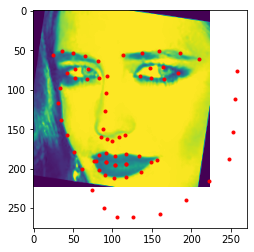

In [9]:
fig = plt.figure()
i=500
sample = face_dataset[i]
show_landmarks(**sample)

In [10]:
dataloader = DataLoader(face_dataset, batch_size=1, shuffle=True, num_workers=4)

In [ ]:
def show_landmarks_batch(sample_batched):
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmark']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2
    grid = utils.make_grid(images_batch.unsqueeze(1))
    fig = plt.figure(figsize=(8,6))
    plt.imshow(grid.numpy().transpose((1, 2, 0))+0.5)
    plt.scatter(landmarks_batch[0,:,0].numpy(),
                    landmarks_batch[0,:,1].numpy(),
                    s=200, marker='.', c='r')
    plt.title('Batch from dataloader')
    #for i in range(batch_size):
        #plt.scatter(landmarks_batch[i,0].numpy()*70 + i * im_size + (i + 1) * grid_border_size,
                    #landmarks_batch[i,1].numpy()*54 + grid_border_size,
                    #s=10, marker='.', c='r')

        #plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmark'].size())

    # observe 4th batch and stop.
    if i_batch == 50:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [ ]:
model_ft = models.resnet18(pretrained=True)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
model_ft.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_ft.fc  = torch.nn.Linear(512, 136, bias=True)
model_ft = model_ft.to(device)
resnet18_criterion = torch.nn.MSELoss()
resnet18_optimizer = torch.optim.Adam(params = model_ft.parameters(), lr = 0.0001)

In [26]:
model_ft.load_state_dict(torch.load('/content/drive/My Drive/prob3_45epoch2.pth'))

<All keys matched successfully>

In [27]:
final=[]
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader):
        inputs, labels = \
            data['image'], data['landmark']
        # zero the parameter gradients
        inputs, labels = inputs.cuda(), labels.cuda()
        resnet18_optimizer.zero_grad()
        outputs = model_ft(inputs.unsqueeze(1))
        loss = resnet18_criterion(outputs.view(-1,68,2), labels)
        loss.backward()
        resnet18_optimizer.step()

        # print statistics
        running_loss += loss.item()
    final.append(running_loss/(i + 1))
print('Finished Training')
#PATH = '/content/drive/My Drive/prob3_45epoch2.pth'
#torch.save(model_ft.state_dict(), PATH)

Finished Training


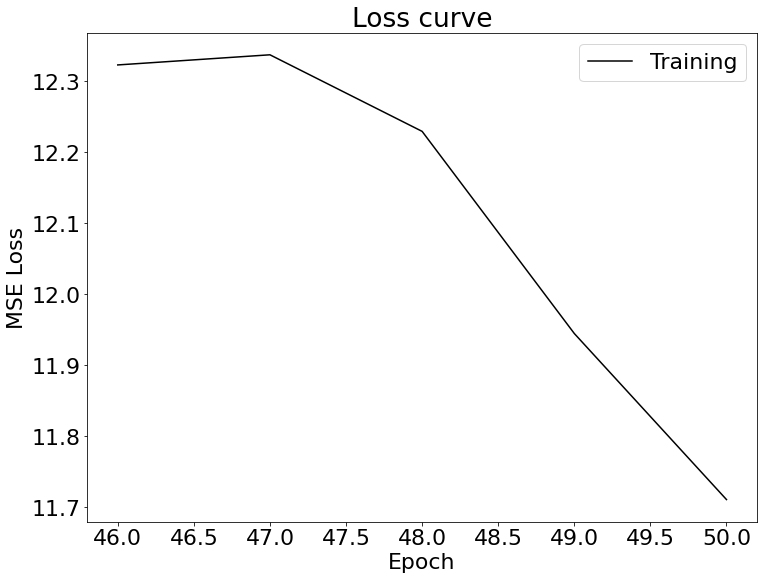

In [30]:
t1 = np.arange(46, 51, 1.0)
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12,9))
plt.plot(t1, final[:], 'k')
plt.legend(['Training', 'Validation'])
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.title('Loss curve')
plt.show()

In [ ]:
!wget https://inst.eecs.berkeley.edu/~cs194-26/fa20/hw/proj4/labels_ibug_300W_test_parsed.xml

In [16]:
tree2 = ET.parse('/content/labels_ibug_300W_test_parsed.xml')
root2 = tree2.getroot()
root_dir2 = 'ibug_300W_large_face_landmark_dataset'

bboxes2 = [] # face bounding box used to crop the image
img_filenames2 = [] # the image names for the whole dataset

for filename in root2[2]:
	img_filenames2.append(os.path.join(root_dir2, filename.attrib['file']))
	box2 = filename[0].attrib
	# x, y for the top left corner of the box, w, h for box width and height
	bboxes2.append([box2['left'], box2['top'], box2['width'], box2['height']])
     
bboxes2 = np.array(bboxes2).astype('float32')

In [32]:
class FaceLandmarksDataset2(Dataset):

    def __init__(self,img_filenames,bboxes):
        self.img_filenames = img_filenames
        self.length=len(img_filenames)
        self.bboxes=bboxes

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        image = io.imread(self.img_filenames[idx])
        self.bboxes[idx,1]=abs(self.bboxes[idx,1])
        self.bboxes[idx,0]=abs(self.bboxes[idx,0])
        image = image[int(self.bboxes[idx,1]):int(self.bboxes[idx,1]+self.bboxes[idx,3]),\
                int(self.bboxes[idx,0]):int(self.bboxes[idx,0]+self.bboxes[idx,2])]
        sample = {'image': image}

        image = rgb2gray(sample['image'])
        image = image.astype('float32')-0.5
        sample['image'] = torch.from_numpy(image)
        return sample

In [33]:
face_dataset2 = FaceLandmarksDataset2(img_filenames2,bboxes2)

In [34]:
def show_landmarks(image, landmark):
    plt.imshow(image)
    plt.scatter(landmark[:,:,0], landmark[:,:,1], marker='.', c='r')
    plt.pause(0.001)

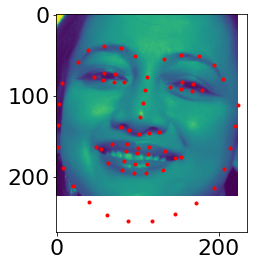

In [45]:
fig = plt.figure()
i=320
sample = face_dataset2[i]
m=torch.from_numpy(transform.resize(sample['image'],(224,224)))
show_landmarks(m,model_ft(m.cuda().unsqueeze(0).unsqueeze(0)).view(-1,68,2).cpu().detach().numpy())

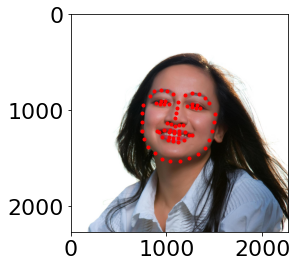

In [46]:
result=model_ft(m.cuda().unsqueeze(0).unsqueeze(0)).view(-1,68,2).cpu().detach().numpy()
image = io.imread(img_filenames2[i])
result[:,:,0]=result[:,:,0]/224*bboxes2[i,3]+int(bboxes2[i,0])
result[:,:,1]=result[:,:,1]/224*bboxes2[i,2]+int(bboxes2[i,1])
plt.imshow(image)
plt.scatter(result[:,:,0], result[:,:,1], marker='.', c='r')

In [ ]:
ids = pd.Series(np.arange(len(face_dataset2)*68*2), name = 'Id')
predictions=[]
for i in range(len(face_dataset2)):
  sample = face_dataset2[i]
  m=torch.from_numpy(transform.resize(sample['image'],(224,224)))
  result=model_ft(m.cuda().unsqueeze(0).unsqueeze(0)).view(-1,68,2).cpu().detach().numpy()
  result[:,:,0]=result[:,:,0]/224*bboxes2[i,3]+int(bboxes2[i,0])
  result[:,:,1]=result[:,:,1]/224*bboxes2[i,2]+int(bboxes2[i,1])
  for j in range(68):
    predictions.append(result[:,:,0][0][j])
    predictions.append(result[:,:,1][0][j])
locations = pd.Series(predictions, name = 'Predicted')
submission_result = pd.concat([ids,locations],axis = 1)
submission_result.to_csv('submission.csv',index = False)

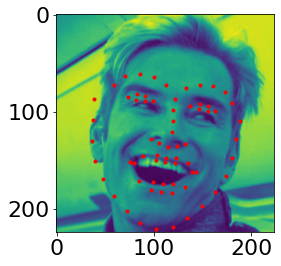

In [49]:
image_tu = io.imread('/content/homelander.jpg')
image_tu = rgb2gray(image_tu)
image_tu = image_tu.astype('float32')-0.5
m=torch.from_numpy(transform.resize(image_tu,(224,224)))
show_landmarks(m,model_ft(m.cuda().unsqueeze(0).unsqueeze(0)).view(-1,68,2).cpu().detach().numpy())